In [4]:
!pip install opencv-python matplotlib opencv-contrib-python

In [5]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from tira_utils import get_input_directory_and_output_directory, normalize_run
import pyterrier as pt
import pandas as pd
import os
import json
from tqdm import tqdm
from glob import glob
from pathlib import Path

Start PyTerrier with version=5.7, helper_version=0.0.7, no_download=True


PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [6]:
def brute_force_sift_matching(image1, image2):
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    
    # image1_gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
    # image2_gray = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)
    
    # print(type(kp1))
    # print(isinstance(kp1, tuple))
    # print(len(kp1))
    # print(len(kp2))
    # print(len(des1))
    # print(len(des2))
    
    if isinstance(kp1, int) or isinstance(kp2, int):
        return [], 0
    elif len(kp1) == 0 or len(kp2) == 0:
        return [], 0

    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
            
    print("Matches: " + str(len(good)))

    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv.drawMatchesKnn(image1, kp1, image2, kp2, good, None,
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    """fig = plt.figure(figsize=(20, 20), dpi=80)
    ax = fig.add_subplot(111)

    ax.imshow(img3, interpolation='nearest')
    # ax.set_aspect(5)

    # plt.imshow(img3, random. rand(8, 90)), 
    plt.show()"""
    return img3, good

def flann_index_kdtree_matcher(image1, image2):
    # Initiate SIFT detector
    sift = cv.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # or pass empty dictionary

    flann = cv.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0, 0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            matchesMask[i] = [1, 0]

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=cv.DrawMatchesFlags_DEFAULT)

    img3 = cv.drawMatchesKnn(image1, kp1, image2, kp2, matches, None,
                             **draw_params)

    plt.imshow(img3, ), plt.show()
    return img3

def flann_index_lsh_matcher(image1, image2):
    # Initiate SIFT detector
    sift = cv.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)

    # FLANN parameters
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm=FLANN_INDEX_LSH,
                        table_number=6,  # 12
                        key_size=12,  # 20
                        multi_probe_level=1)  # 2
    search_params = dict(checks=50)  # or pass empty dictionary

    flann = cv.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0, 0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            matchesMask[i] = [1, 0]

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=cv.DrawMatchesFlags_DEFAULT)

    img3 = cv.drawMatchesKnn(image1, kp1, image2, kp2, matches, None,
                             **draw_params)

    plt.imshow(img3, ), plt.show()
    return img3

In [22]:
def is_cuda_cv(): # 1 == using cuda, 0 = not using cuda
    try:
        count = cv.cuda.getCudaEnabledDeviceCount()
        if count > 0:
            return "true"
        else:
            return "false"
    except:
        return "exception"

def brute_force_sift_matching_cuda(image1, image2):
    # Convert the images to grayscale
    img1_gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
    img2_gray = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)

    # Check if CUDA is available
    if cv.cuda.getCudaEnabledDeviceCount() > 0:
        print("CUDA is available, using CUDA for feature matching")
        # Use CUDA SIFT detector
        sift = cv.cuda_SIFT.create()
        # Use CUDA BFMatcher
        bf = cv.cuda_BFMatcher()
    else:
        print("CUDA is not available, using regular SIFT and BFMatcher")
        # Use regular SIFT detector
        sift = cv.SIFT_create()
        # Use regular BFMatcher
        bf = cv.BFMatcher()

    # Detect keypoints of original image
    (kp1,des1) = sift.detectAndCompute(img1_gray, None)

    # Detect keypoints of rotated image
    (kp2,des2) = sift.detectAndCompute(img2_gray, None)

    # Do matching
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
            
    print("Matches: " + str(len(good)))

    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv.drawMatchesKnn(image1, kp1, image2, kp2, good, None,
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    fig = plt.figure(figsize=(20, 20), dpi=80)
    ax = fig.add_subplot(111)

    ax.imshow(img3, interpolation='nearest')
    # ax.set_aspect(5)

    # plt.imshow(img3, random. rand(8, 90)), 
    plt.show()
    
    return img3, good

def brute_force_sift_matching_cuda2(image1, image2):
    # Load the images onto the GPU
    cuMat1 = cv.cuda_GpuMat()
    cuMat2 = cv.cuda_GpuMat()
    cuMat1.upload(image1)
    cuMat2.upload(image2)

    # Convert the color on the GPU
    cuMat1 = cv2.cuda.cvtColor(cuMat1, cv.COLOR_BGR2GRAY)
    cuMat2 = cv2.cuda.cvtColor(cuMat2, cv.COLOR_BGR2GRAY)

    # Create the CUDA ORB detector and detect keypoints/descriptors
    kps1, descs1 = orb.detectAndComputeAsync(cuMat1, None) # Both are returned as GPU Mats
    kps2, descs2 = orb.detectAndComputeAsync(cuMat2, None)

    # Download the keypoints from the GPU memory
    kps1_downloaded = kps1.download()
    kps2_downloaded = kps2.download()

    # Do matching
    matches = bf.match(des1,des2)
    
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
            
    print("Matches: " + str(len(good)))

    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv.drawMatchesKnn(image1, kp1, image2, kp2, good, None,
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Show the final output image
    # cv.imshow('Matched Features', img3)
    # cv.waitKey(0)
    # cv.destroyWindow('Matched Features')
    
    return img3, good

In [8]:
import glob

image_paths = glob.glob('dataset22/images/I0*/*/image.webp')

In [9]:
images = [cv.imread(image_path) for image_path in image_paths]

In [10]:
img1 = images[0]
img2 = images[1]
img3 = images[2]

In [11]:
# Displaying the image
# cv.imshow('image', img)

pair1_img, pair1_good_matches = brute_force_sift_matching(img1, img2)

# cv.imwrite('image_results/brute_force_sift_matching.png',sift_matching_img)

Matches: 137


In [23]:
is_cuda_cv()

'false'

CUDA is not available, using regular SIFT and BFMatcher
Matches: 518


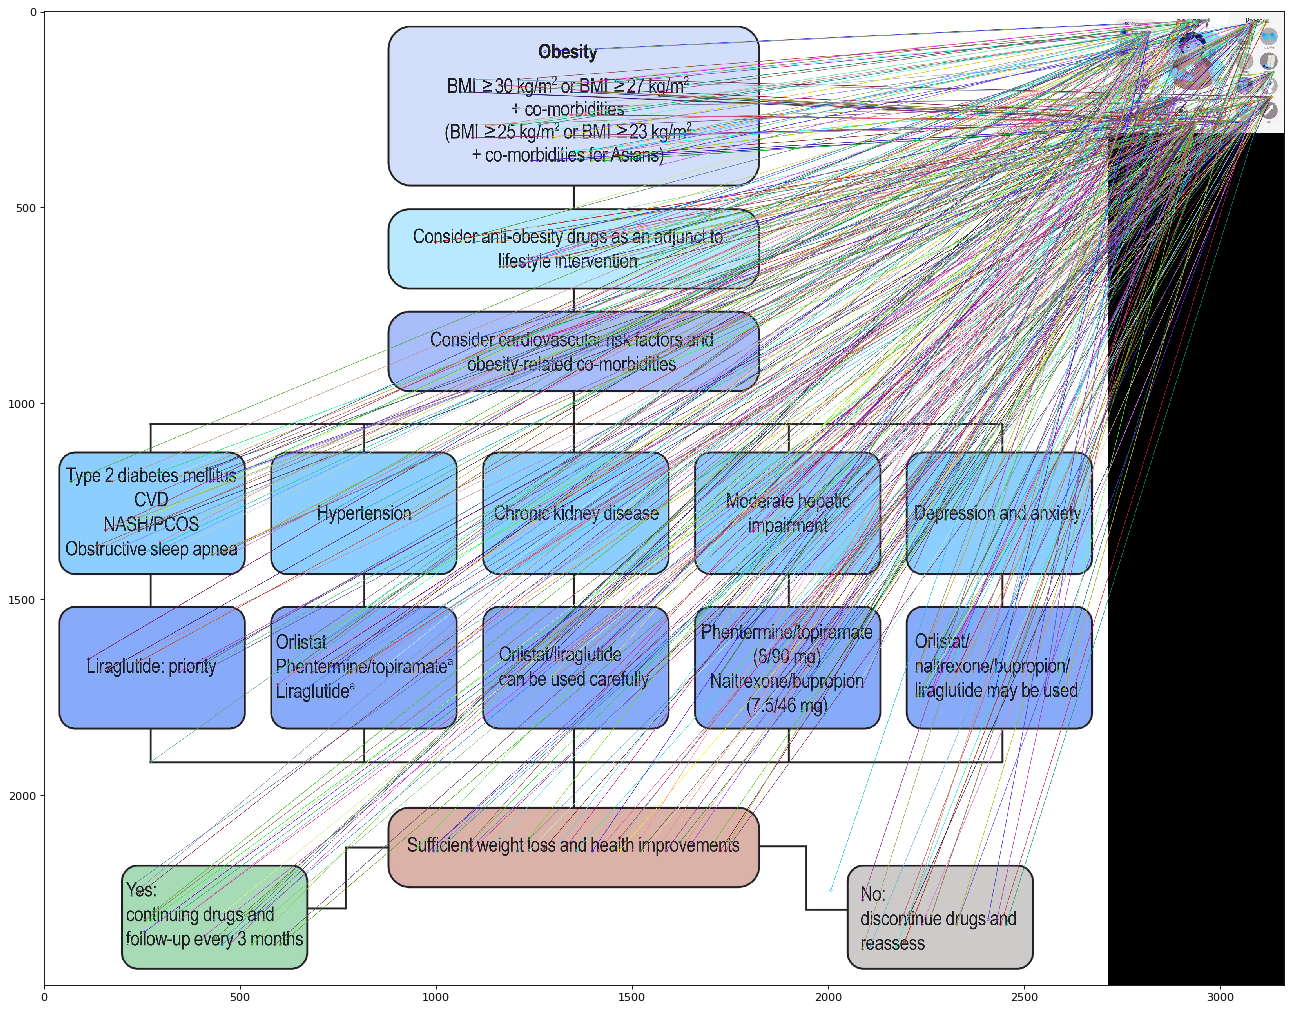

In [13]:
pair2_img, pair2_good_matches = brute_force_sift_matching_cuda(img1, img3)
# cv.imshow('image', pair2_img)

In [10]:
topic_img = cv.imread("image_results/topic_generated.png")
best_match_img = []
highest_match_count = 0
img_num = 0

for image in images:
    print(img_num)
    img_num += 1
    img, good_matches = brute_force_sift_matching_cuda(topic_img, image)
    
    if highest_match_count < len(good_matches):
        best_match_img = img
        highest_match_count = len(good_matches)

print(highest_match_count)
cv.imshow('image', best_match_img)
    
    

0
CUDA is not available, using regular SIFT and BFMatcher


AttributeError: module 'cv2' has no attribute 'xfeatures2d'

In [ ]:
import cv2
import numpy as np

# Read the images as normal
npMat1 = cv2.imread("path_to_image_to_be_corrected")
npMat2 = npMat1.copy()#cv2.imread("path_to_reference_image")

# Load the images onto the GPU
cuMat1 = cv2.cuda_GpuMat()
cuMat2 = cv2.cuda_GpuMat()
cuMat1.upload(npMat1)
cuMat2.upload(npMat2)

# Convert the color on the GPU
cuMat1 = cv2.cuda.cvtColor(cuMat1, cv2.COLOR_BGR2GRAY)
cuMat2 = cv2.cuda.cvtColor(cuMat2, cv2.COLOR_BGR2GRAY)

# Create the CUDA ORB detector and detect keypoints/descriptors
kps1, descs1 = orb.detectAndComputeAsync(cuMat1, None) # Both are returned as GPU Mats
kps2, descs2 = orb.detectAndComputeAsync(cuMat2, None)

# Download the keypoints from the GPU memory
kps1_downloaded = kps1.download()
kps2_downloaded = kps2.download()

In [49]:
topic_xml_data = open('dataset22/topics.xml', 'r').read() 

topics_dataframe = pd.read_xml(topic_xml_data)
topics_dataframe

,number,title,description,narrative
0,1,Should teachers get tenure?,A user has heard that some countries do give t...,Highly relevant arguments make a clear stateme...
1,2,Is vaping with e-cigarettes safe?,When considering to switch from smoking to vap...,Highly relevant arguments support or deny the ...
2,3,Should insider trading be allowed?,"Since many marketplaces are liberalized, the u...",Highly relevant arguments argue for or against...
3,4,Should corporal punishment be used in schools?,Discipline in schools is associated with bette...,Highly relevant arguments include ones that ar...
4,5,Should social security be privatized?,"The costs of social security are enormous, and...",Highly relevant arguments take the pro or con ...
5,6,Is a college education worth it?,A lot of educational resources can be found on...,Highly relevant arguments make a statement on ...
6,7,Should felons who have completed their sentenc...,People who committed a serious crime have posi...,Highly relevant arguments consider reasons for...
7,8,Should abortion be legal?,It is an open question at what point human lif...,Highly relevant arguments take a stance for or...
8,9,Should students have to wear school uniforms?,"Promoting equality is a key goal at school, an...",Highly relevant arguments consider the benefit...
9,10,Should any vaccines be required for children?,"Anti-vaccination movements are on the rise, an...",Highly relevant arguments name one or more vac...


In [44]:
topics_dataframe['title'].head(5)

0                       Should teachers get tenure?
1                 Is vaping with e-cigarettes safe?
2                Should insider trading be allowed?
3    Should corporal punishment be used in schools?
4             Should social security be privatized?
Name: title, dtype: object

In [48]:
topics_dataframe.iloc[0]['description']

"A user has heard that some countries do give teachers tenure and others don't. Interested in the reasoning for or against tenure, the user searches for positive and negative arguments. The situation of school teachers vs. university professors is of interest."